In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
ticker.EngFormatter.ENG_PREFIXES.update({9:"B"}) # For cleaner formatting

from rliable import library as rly
from rliable import metrics
from rliable import plot_utils

from scipy.stats import trim_mean, bootstrap

sns.set()

In [2]:
colors = sns.color_palette()

# baselines are PPO, SAC, TDMPC (no planning), TDMPC plannig, SHAC, FOWM
colors = {"PPO": colors[2],
         "SAC": colors[3],
         # "TDMPC (no planning)": colors[4],
         "SHAC": colors[0],
         "TDMPC2": colors[4],
         "PWM": colors[1]}

# used to gather normalisation values
perf_scales = {}

# set legened helpers
fancy_legend = []
for k in colors.keys():
    if k == "PWM":
        patch = mpatches.Patch(color=colors[k], label="PWM (ours)")
    else:
        patch = mpatches.Patch(color=colors[k], label=k)
    fancy_legend.append(patch)


In [3]:
# General helper functions

fps_dict = {"ppo": {"anymal": 18300, "humanoid": 18500, "ant": 222800, "humanoidsnu": 21480, "hopper": 185000, "claw":169000},
            "sac": {"anymal": 3000, "humanoid": 3400, "ant":21000, "humanoidsnu": 6170 , "hopper":18200, "claw": 28300},
            "svg": {"ant": 240},
           "shac": {"anymal":1140, "humanoid":785, "ant": 12950, "humanoidsnu": 960, "hopper":33100, "claw": 510},
           "ahac": {"anymal": 1180, "humanoid": 730,"ant": 12100, "humanoidsnu": 800, "hopper":24900, "claw": 720}}

sample_rates = {"hopper": "10s", "ant": "30s", "anymal": "120s", "humanoid": "120s", "humanoidsnu": "120s"}

def process_time_data(filepath, resample_rate="30s", col="rewards", index=True, variance=False, smooth=0.99):
    alg, env = filepath.split("/")[-1].split("_")[:2]
    
    data = pd.read_csv(filepath)
    if index:
        data.index = pd.to_timedelta(data["Relative Time (Process)"], unit="s")
    else:
        data.index = pd.to_timedelta(data["Relative Time (Process)"])
    data = data.dropna(how="all")
    data = data.interpolate()
    data = data.dropna()
    data.index -= data.index[0]
    if alg in fps_dict:
        fps = fps_dict[alg][env]
        data["global_step"] = (data.index.total_seconds()*fps).astype(int)
    else:
        print("WARNING: no fps for", alg)
    
    if resample_rate:
        data = data.resample(resample_rate).interpolate()
    if variance:
        data[f"{col}"] = data[data.columns[data.columns.str.endswith(f"{col}")]].mean(axis=1)
        std = data[data.columns[data.columns.str.endswith(f"{col}")]].std(axis=1)
        data[f"{col}_min"] = data[f"{col}"] - std
        data[f"{col}_max"] = data[f"{col}"] + std
    else:
        data[f"{col}"] = data[data.columns[data.columns.str.endswith(f"{col}")]].mean(axis=1)
        data[f"{col}_min"] = data[data.columns[data.columns.str.endswith(f"{col}__MIN")]].min(axis=1)
        data[f"{col}_max"] = data[data.columns[data.columns.str.endswith(f"{col}__MAX")]].max(axis=1)
        
    if smooth:
        data[f"{col}"] = data[f"{col}"].ewm(alpha=1-smooth).mean()
        data[f"{col}_min"] = data[f"{col}_min"].ewm(alpha=1-smooth).mean()
        data[f"{col}_max"] = data[f"{col}_max"].ewm(alpha=1-smooth).mean()
    return data

def process_ahac_step_data(filepath, col="rewards", steps=31.5*512, variance=False, smooth=False):
    data = pd.read_csv(filepath)
    data["global_step"] *= steps
    data.index = data["global_step"]
    # data = data.drop("global_step", axis=1)
    data = data.dropna(how="all")
    s = (data.index.to_series() / 10000).astype(int)
    # data = data.groupby(s).mean().set_index(s.groupby(s).apply(lambda x: np.mean(x.index)) )
    
    if variance:
        data[f"{col}"] = data[data.columns[data.columns.str.endswith(f"{col}")]].mean(axis=1)
        std = data[data.columns[data.columns.str.endswith(f"{col}")]].std(axis=1)
        data[f"{col}_min"] = data[f"{col}"] - std
        data[f"{col}_max"] = data[f"{col}"] + std
    else:
        data[f"{col}"] = data[data.columns[data.columns.str.endswith(f"{col}")]].mean(axis=1)
        data[f"{col}_min"] = data[data.columns[data.columns.str.endswith(f"{col}__MIN")]].min(axis=1)
        data[f"{col}_max"] = data[data.columns[data.columns.str.endswith(f"{col}__MAX")]].max(axis=1)
        
    if smooth:
        data[f"{col}"] = data[f"{col}"].ewm(alpha=1-smooth).mean()
        data[f"{col}_min"] = data[f"{col}_min"].ewm(alpha=1-smooth).mean()
        data[f"{col}_max"] = data[f"{col}_max"].ewm(alpha=1-smooth).mean()
    return data

def process_time_data_iqm(filepath, resample_rate="90s", col="rewards", index=True, smooth=None):
    alg, env = filepath.split("/")[-1].split("_")[:2]

    iqm = lambda scores: trim_mean(scores, proportiontocut=0.25).flatten()

    data = pd.read_csv(filepath)

    # remove duplicate columns 
    mi = ~data.columns.str.endswith(f"__MIN")
    ma = ~data.columns.str.endswith(f"__MAX")
    data = data[data.columns[mi&ma]]

    data = data.interpolate()
    if index:
        data.index = pd.to_timedelta(data["Relative Time (Process)"], unit="s")
    else:
        data.index = pd.to_timedelta(data["Relative Time (Process)"])
    data = data.drop("Relative Time (Process)", axis=1)
    data = data.dropna()
    if resample_rate:
        data = data.resample(resample_rate).first().interpolate()
    
    data.index -= data.index[0]
    
    if alg in fps_dict:
        fps = fps_dict[alg][env]
        data["global_step"] = (data.index.total_seconds()*fps).astype(int)
    else:
        print("WARNING: no fps for", alg)

    vals = data[data.columns[data.columns.str.endswith(f"{col}")]].values
    vals = vals.T # flip to be num_runs x num_steps
    vals = np.expand_dims(vals, 1)
    dic = {0: vals}

    iqm_scores, iqm_cis = rly.get_interval_estimates(dic, iqm, reps=2000)
    data[f"{col}"] = iqm_scores[0]
    data[f"{col}_min"] = iqm_cis[0][0]
    data[f"{col}_max"] = iqm_cis[0][1]
            
    if smooth:
        data[f"{col}"] = data[f"{col}"].ewm(alpha=1-smooth).mean()
        data[f"{col}_min"] = data[f"{col}_min"].ewm(alpha=1-smooth).mean()
        data[f"{col}_max"] = data[f"{col}_max"].ewm(alpha=1-smooth).mean()
    return data

def process_step_data_iqm(filepath, row="Step", col="rewards", smooth=None, downsample=10):
    alg, env = filepath.split("/")[-1].split("_")[:2]

    iqm = lambda scores: trim_mean(scores, proportiontocut=0.25).flatten()

    data = pd.read_csv(filepath)

    # remove duplicate columns 
    mi = ~data.columns.str.endswith(f"__MIN")
    ma = ~data.columns.str.endswith(f"__MAX")
    data = data[data.columns[mi&ma]]

    data = data.interpolate()
    data = data.dropna()

    data.index = data[row]
    data = data.drop(row, axis=1)
    data = data.iloc[::downsample]

    vals = data[data.columns[data.columns.str.endswith(f"{col}")]].values
    vals = vals.T # flip to be num_runs x num_steps
    vals = np.expand_dims(vals, 1)
    dic = {0: vals}

    iqm_scores, iqm_cis = rly.get_interval_estimates(dic, iqm, reps=2000)
    data[f"{col}"] = iqm_scores[0]
    data[f"{col}_min"] = iqm_cis[0][0]
    data[f"{col}_max"] = iqm_cis[0][1]
            
    if smooth:
        data[f"{col}"] = data[f"{col}"].ewm(alpha=1-smooth).mean()
        data[f"{col}_min"] = data[f"{col}_min"].ewm(alpha=1-smooth).mean()
        data[f"{col}_max"] = data[f"{col}_max"].ewm(alpha=1-smooth).mean()
    return data

# Aggregate results

In [4]:
# Performance metric

# from PPO
perf_scales = {'ant': 6604.663357204862,
                 'hopper': 4742.296956380208,
                 'anymal': 12028.991672092014,
                 'humanoid': 7292.7856852213545,
                 'humanoidsnu': 4246.042073567708}

# dict of alg: np.array(num_runs x num_tasks)
score_dict = {}

iqm = lambda scores: np.array([metrics.aggregate_iqm(scores[..., frame])
                               for frame in range(scores.shape[-1])])

for alg in ["ppo", "sac", "shac", "tdmpc2", "pwm"]:
    print(f"alg: {alg}")
    scores = []
    for env in ["hopper", "ant", "anymal", "humanoid", "humanoidsnu"]:
        if alg not in ["tdmpc2", "pwm"]:
            col = "rewards/time" if alg in ["ppo", "sac"] else "rewards"
            data = process_time_data_iqm(f"data/{alg}_{env}_time.csv", sample_rates[env], col)
        else:
            col = "train/episode_reward" if alg =="tdmpc2" else "rewards"
            data = process_step_data_iqm(f"data/{alg}_{env}.csv", col=col)
            
        # get max index and drop IQM
        j = data[col].argmax()
        data = data.drop(col, axis=1)
        vals = data[data.columns[data.columns.str.endswith(f"{col}")]].iloc[j].values
        print(f"Read {len(vals)} for {env}") 
        scores.append(vals/perf_scales[env])
    scores = np.expand_dims(np.array(scores), -1)
    score_dict.update({alg.upper(): scores})

tau = np.linspace(0.5, 2.0, 100)
reps = 2000
score_distributions, score_distributions_cis = rly.create_performance_profile(score_dict, tau, reps=reps, confidence_interval_size=0.95)
iqm_scores, iqm_cis = rly.get_interval_estimates(score_dict, iqm, reps=reps)

alg: ppo
Read 10 for hopper
Read 10 for ant
Read 10 for anymal
Read 10 for humanoid
Read 10 for humanoidsnu
alg: sac
Read 10 for hopper
Read 10 for ant
Read 10 for anymal
Read 10 for humanoid
Read 10 for humanoidsnu
alg: shac
Read 10 for hopper
Read 10 for ant
Read 10 for anymal
Read 10 for humanoid
Read 10 for humanoidsnu
alg: tdmpc2
Read 5 for hopper
Read 5 for ant
Read 5 for anymal
Read 5 for humanoid
Read 5 for humanoidsnu
alg: pwm
Read 5 for hopper
Read 5 for ant
Read 5 for anymal
Read 5 for humanoid
Read 5 for humanoidsnu


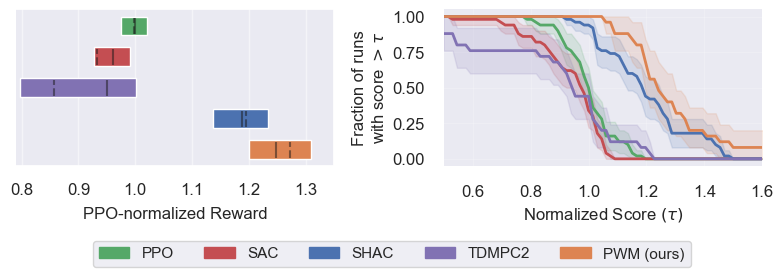

In [27]:
# Ant Figure
# fig, ax = plt.subplot_mosaic("0001..222.333", figsize=(9,1.7), sharey=False)
fig, ax = plt.subplot_mosaic("222333", figsize=(8,2.5), sharey=False)
smooth=None
env = "ant"

# plot CI and median
h=0.6
labels = ["PPO", "SAC", "TDMPC2", "SHAC", "PWM"][::-1]

plot_utils.plot_performance_profiles(
  score_distributions, tau,
  performance_profile_cis=score_distributions_cis,
  colors=colors,
  xlabel=r'PPO-normalized Score $(\tau)$',
  labelsize='medium',
  ax=ax['3'])
ax['3'].tick_params(axis='both', which='major', labelsize='medium')
ax['3'].set_xlabel(r'Normalized Score $(\tau)$', fontsize='medium')
ax['3'].set_ylabel('Fraction of runs\nwith score $> \\tau$', fontsize='medium')
ax['3'].set_xlim((0.5, 1.6))


for idx, alg in enumerate(labels):
    ax['2'].barh(y=idx, width=iqm_cis[alg][1] - iqm_cis[alg][0], height=0.6, left=iqm_cis[alg][0], alpha=1.0, color=colors[alg])
    ax['2'].vlines(x=iqm_scores[alg],
        ymin=idx - (7.5 * h / 16),
        ymax=idx + (6.5 * h / 16),
        color='k',
        alpha=0.5)
    ax['2'].vlines(x=score_dict[alg].mean(),
        ymin=idx - (7.5 * h / 16),
        ymax=idx + (6.5 * h / 16),
        color='k',
        alpha=0.5,
        linestyle="dashed")

# cleanup grid and axis
ax['2'].spines['left'].set_visible(False)
ax['2'].grid(False)    
ax['2'].grid(True, axis='x', alpha=0.5)    
ax['2'].set_yticks([])
ax['2'].set_xlabel("PPO-normalized Reward", fontsize='medium')
ax['2'].tick_params(axis='both', which='major', labelsize='medium')
ax['2'].set_xlim((0.79, 1.35))
ax['2'].tick_params(axis='x', pad=6)
ax['2'].xaxis.labelpad = 6

# plt.tight_layout(h_pad=10, w_pad=3)
plt.tight_layout()

# Create fancy legend
fig.legend(handles=fancy_legend, loc='center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=False, ncol=len(fancy_legend))
plt.savefig("../figures/dflex_results_agg.pdf", bbox_inches="tight", pad_inches=0)

/var/folders/cj/888lfvn14_38zynpt2hh94yw0000gn/T/ipykernel_8569/2645949566.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


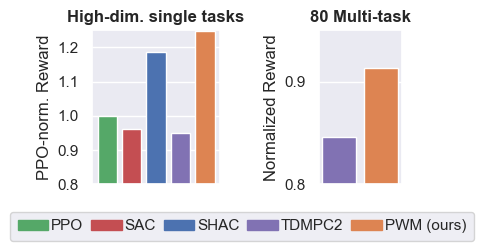

In [28]:
#teaser figure
f, ax = plt.subplot_mosaic("000..11", figsize=(4,2))
ax1, ax2 = ax['0'], ax['1']
i = 0
for alg, rew in iqm_scores.items():
    ax1.bar(i, rew, color=colors[alg])
    i += 1

ax1.set_ylim((0.8, 1.25))
ax1.set_ylabel("PPO-norm. Reward")
ax1.set_xticks([])
ax1.set_title("High-dim. single tasks", fontweight="bold")

# Load data and process into metrics
pwm_data = pd.read_csv("data/mt80_results_h3.csv")
tdmpc_data = pd.read_csv("data/tdmpc2_mt80_scores.csv")

norm = 1000
tdmpc_data = pd.read_csv("data/tdmpc2_mt80_scores.csv")
tdmpc_data = tdmpc_data.sort_values(by="task")
seeds = tdmpc_data.seed.max()+1
tdmpc_data["score"] = tdmpc_data.episode_reward/norm
idx = tdmpc_data.task.str.startswith("mw")
tdmpc_data.loc[idx, "score"] = tdmpc_data[idx].episode_success
tdmpc_scores = tdmpc_data.score.values.reshape((-1, seeds, 1))

pwm_data = pd.read_csv("data/mt80_results.csv")
pwm_data = pwm_data.sort_values(by="task")
pwm_data["score"] = pwm_data.episode_reward/norm
idx = pwm_data.task.str.startswith("mw")
pwm_data.loc[idx, "score"] = pwm_data[idx].episode_success
pwm_scores = pwm_data.score.values[..., None, None]

# score dict is {algo: np.array num_exp x seeds x episode_rewards}
score_dict_mt = {
            "TDMPC2": tdmpc_scores,         
            "PWM": pwm_scores,
            }

iqm = lambda scores: np.array([metrics.aggregate_iqm(scores[..., frame])
                               for frame in range(scores.shape[-1])])

tau = np.linspace(0.0, 1.0, 100)
reps = 2000
iqm_scores_mt, iqm_cis = rly.get_interval_estimates(score_dict_mt, iqm, reps=reps)

i=0
for alg, rew in iqm_scores_mt.items():
    ax2.bar(i, rew, color=colors[alg])
    i += 1

ax2.set_ylim((0.8, 0.95))
ax2.set_ylabel("Normalized Reward")
ax2.set_xticks([])
ax2.set_yticks([0.8, 0.9])
ax2.set_title("80 Multi-task", fontweight="bold")


f.legend(handles=fancy_legend, loc='center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=False, ncol=len(fancy_legend), columnspacing=0.5, handletextpad=0.2, borderpad=0.5)
plt.tight_layout()
# plt.savefig("../figures/teaser.pdf", bbox_inches="tight", pad_inches=0)

alg=ppo
Perf scale 6604.663357204862
max reward 1.00
max std 0.12
alg=sac
max reward 0.95
max std 0.08
alg=shac
max reward 1.16
max std 0.13


/var/folders/cj/888lfvn14_38zynpt2hh94yw0000gn/T/ipykernel_8569/1865009075.py:128: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


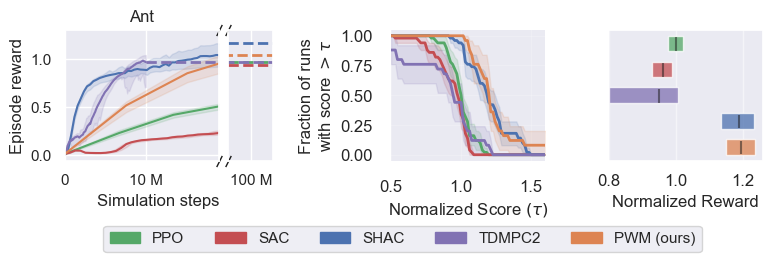

In [21]:
# Ant Figure
fig, ax = plt.subplot_mosaic("0001..222.333", figsize=(9,1.7), sharey=False)
smooth=None
env = "ant"
    
for alg in ["ppo", "sac", "shac"]:
    print(f"alg={alg}")
    
    # load data
    col = "rewards" if alg in ["shac", "ahac"] else "rewards/time"
    data = process_time_data_iqm(f"data/{alg}_{env}_time.csv", sample_rates[env], col, smooth=smooth)

    if alg == "ppo":
        perf_scale = data[col].max()
        print("Perf scale", perf_scale)
        perf_scales.update({env:perf_scale})
        
    j = data[col].argmax()
    print("max reward {:3.2f}".format(data[col][j]/perf_scale))
    print("max std {:3.2f}".format(data[data.columns[data.columns.str.endswith(f"{col}")]].iloc[j].std()/perf_scale))
        
    # Scale data proportionally
    data[[col, f"{col}_max", f"{col}_min"]] /= perf_scale
        
    ### Plot against steps
    span = (0, 35e6) # AHAC range + some
    slice = data[(data.global_step >= span[0]).values & (data.global_step <= span[1]).values]
    ax['0'].plot(slice.global_step, slice[col], c=colors[alg.upper()])
    ax['0'].fill_between(slice.global_step, slice[f"{col}_min"], slice[f"{col}_max"], alpha=0.15, color=colors[alg.upper()])
    ax['0'].set_xlim((0, 30492000)) # AHAC span

    # Plot against very large steps. Only PPO gets plotted
    span = (100e6 - 10e6, 100e6 + 10e6)
    # if alg in ["ppo"]:
    if alg in []:
        slice = data[(data.global_step > span[0]).values & (data.global_step < span[1]).values]
        ax['1'].plot(slice.global_step, slice[col], c=colors[alg.upper()])
        ax['1'].fill_between(slice.global_step, slice[f"{col}_min"], slice[f"{col}_max"], alpha=0.15, color=colors[alg.upper()])
    else:
        n = 5
        ax['1'].plot(np.linspace(span[0],span[1], n), data[f"{col}"].dropna().iloc[-1].repeat(n), '--', c=colors[alg.upper()], lw=2)
    ax['1'].set_xlim(span)


# plot TDMPC
col = "train/episode_reward"
data = process_step_data_iqm("data/tdmpc2_ant.csv", col=col, downsample=500, smooth=0.8)
data[f"{col}"] /= perf_scale
data[f"{col}_min"] /= perf_scale
data[f"{col}_max"] /= perf_scale
ax['0'].plot(data.index, data[col], color=colors["TDMPC2"])
ax['0'].fill_between(data.index, data[f"{col}_min"], data[f"{col}_max"], color=colors["TDMPC2"], alpha=0.15)
last = data.index[-1]
span = (last, span[1])
ax['0'].plot(np.linspace(span[0],span[1], n), data[f"{col}"].dropna().iloc[-1].repeat(n), '--', c=colors["TDMPC2"], lw=2)
ax['1'].plot(np.linspace(span[0],span[1], n), data[f"{col}"].dropna().iloc[-1].repeat(n), '--', c=colors["TDMPC2"], lw=2)

# plot PWM
col = "rewards"
data = process_step_data_iqm("data/pwm_ant.csv", col=col, downsample=500, smooth=0.8)
data[f"{col}"] /= perf_scale
data[f"{col}_min"] /= perf_scale
data[f"{col}_max"] /= perf_scale
ax['0'].plot(data.index, data[col], color=colors["PWM"])
ax['0'].fill_between(data.index, data[f"{col}_min"], data[f"{col}_max"], color=colors["PWM"], alpha=0.15)
last = data.index[-1]
span = (last, span[1])
ax['0'].plot(np.linspace(span[0],span[1], n), data[f"{col}"].dropna().iloc[-1].repeat(n), '--', c=colors["PWM"], lw=2)
ax['1'].plot(np.linspace(span[0],span[1], n), data[f"{col}"].dropna().iloc[-1].repeat(n), '--', c=colors["PWM"], lw=2)

        
# Formatting
ax['0'].set_xlabel("Simulation steps", loc="right")
ax['0'].set_ylabel("Episode reward")
ax['0'].set_xlim((0, 19e6))
ax['0'].xaxis.set_major_formatter(ticker.EngFormatter())
ax['1'].xaxis.set_major_formatter(ticker.EngFormatter())
ax['1'].set_xlabel('')
ax['1'].get_yaxis().set_visible(False)
ax['1'].set_xticks([100e6])
ax['1'].set_ylim(ax['0'].get_ylim())


# add continuity ticks
d = 2.  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=8,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax['0'].plot([1, 1], [0, 1], transform=ax['0'].transAxes, **kwargs)
ax['1'].plot([0, 0], [0, 1], transform=ax['1'].transAxes, **kwargs)

# plot CI and median
h=0.6
labels = ["PPO", "SAC", "TDMPC2", "SHAC", "PWM"][::-1]

plot_utils.plot_performance_profiles(
  score_distributions, tau,
  performance_profile_cis=score_distributions_cis,
  colors=colors,
  xlabel=r'PPO-normalized Score $(\tau)$',
  labelsize='medium',
  ax=ax['2'])
ax['2'].tick_params(axis='both', which='major', labelsize='medium')
ax['2'].set_xlabel(r'Normalized Score $(\tau)$', fontsize='medium')
ax['2'].set_ylabel('Fraction of runs\nwith score $> \\tau$', fontsize='medium')
ax['2'].set_xlim((0.5, 1.6))


for idx, alg in enumerate(labels):
    ax['3'].barh(y=idx, width=iqm_cis[alg][1] - iqm_cis[alg][0], height=0.6, left=iqm_cis[alg][0], alpha=0.75, color=colors[alg])
    ax['3'].vlines(x=iqm_scores[alg],
        ymin=idx - (7.5 * h / 16),
        ymax=idx + (6.5 * h / 16),
        color='k',
        alpha=0.5)

# cleanup grid and axis
ax['3'].spines['left'].set_visible(False)
ax['3'].grid(False)    
ax['3'].grid(True, axis='x', alpha=0.5)    
ax['3'].set_yticks([])
ax['3'].set_xlabel("Normalized Reward", fontsize='medium')
ax['3'].tick_params(axis='both', which='major', labelsize='medium')
ax['0'].set_title("Ant")
# ax['3'].set_xlim((0.79, 1.3))


# plt.tight_layout(h_pad=10, w_pad=3)
plt.tight_layout()

# Create fancy legend
# ax['1'].legend(handles=fancy_legend, loc='upper center', bbox_to_anchor=(3.7, -0.4),
#           fancybox=True, shadow=False, ncol=5)
fig.legend(handles=fancy_legend, loc='center', bbox_to_anchor=(0.5, -0.35), fancybox=True, shadow=False, ncol=len(fancy_legend))
plt.savefig("../figures/dflex_results.pdf", bbox_inches="tight")

# Locomotion Sweep

=== Doing hopper ===
alg=ppo
perf_scale: 4742.296956380208
max reward 1.00
max std 0.11
alg=sac
max reward 0.87
max std 0.16
alg=shac
max reward 1.02
max std 0.03
TDMPC2
max reward 4027.36
max std 1768.13
PWM
max reward 5680.46
max std 2303.80
=== Doing ant ===
alg=ppo
perf_scale: 6604.663357204862
max reward 1.00
max std 0.12
alg=sac
max reward 0.95
max std 0.08
alg=shac
max reward 1.16
max std 0.13
TDMPC2
max reward 6591.92
max std 2708.04
PWM
max reward 9672.00
max std 4024.53
=== Doing anymal ===
alg=ppo
perf_scale: 12028.991672092014
max reward 1.00
max std 0.03
alg=sac
max reward 0.98
max std 0.06
alg=shac
max reward 1.26
max std 0.04
TDMPC2
max reward 11787.28
max std 4804.05
PWM
max reward 13927.74
max std 5764.66
=== Doing humanoid ===
alg=ppo
perf_scale: 7292.7856852213545
max reward 1.00
max std 0.05
alg=sac
max reward 1.04
max std 0.04
alg=shac
max reward 1.15
max std 0.04
TDMPC2
max reward 7476.02
max std 3268.36
PWM
max reward 8661.34
max std 3585.11
=== Doing humanoidsnu

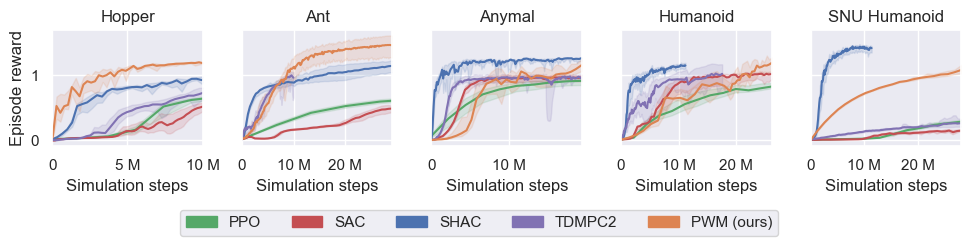

In [22]:
# load svg results seperately
iqm = lambda scores: trim_mean(scores, proportiontocut=0.25).flatten()

fig, ax = plt.subplots(1, 5, sharey=True, figsize=(10,2.2))
ax = ax.flatten()

smooth=None

for i, env in enumerate(["hopper", "ant", "anymal", "humanoid", "humanoidsnu"]):
    print(f"=== Doing {env} ===")
    
    for alg in ["ppo", "sac", "shac"]:
        print(f"alg={alg}")
        
        # load data
        col = "rewards/time" if alg in ["ppo", "sac"] else "rewards"
        data = process_time_data_iqm(f"data/{alg}_{env}_time.csv", sample_rates[env], col, smooth=smooth)

        if alg == "ppo":
            perf_scale = data[col].max()
            print("perf_scale:", perf_scale)
            perf_scales.update({env: perf_scale})
            
        j = data[col].argmax()
        print("max reward {:3.2f}".format(data[col][j]/perf_scale))
        print("max std {:3.2f}".format(data[data.columns[data.columns.str.endswith(f"{col}")]].iloc[j].std()/perf_scale))
            
        # Scale data proportionally
        data[[col, f"{col}_max", f"{col}_min"]] /= perf_scale
            
        # Plot against steps
        ax[i].plot(data.global_step, data[col], c=colors[alg.upper()])
        ax[i].fill_between(data.global_step, data[f"{col}_min"], data[f"{col}_max"], alpha=0.15, color=colors[alg.upper()])
        ax[i].set_xlabel("Simulation steps")
        ax[i].xaxis.set_major_formatter(ticker.EngFormatter())
        # ax[i].set_xlim((0,data.global_step.max()))

        # # Plot against time
        # ax[i+4].plot(data.index.total_seconds()/60, data[col], c=colors[alg.upper()])
        # ax[i+4].fill_between(data.index.total_seconds()/60, data[f"{col}_min"], data[f"{col}_max"], alpha=0.3, color=colors[alg.upper()])
        # ax[i+4].set_xlabel("Time (min)")
        # ax[i+4].set_xlim((0,(data.index.total_seconds()/60).max()))


    if env in ["anymal"]:
        ds = 5
    else:
        ds=500

    # plot TDMPC
    print("TDMPC2")
    col = "train/episode_reward"
    data = process_step_data_iqm(f"data/tdmpc2_{env}.csv", col=col, downsample=ds, smooth=0.6)
    data[f"{col}"] /= perf_scale
    data[f"{col}_min"] /= perf_scale
    data[f"{col}_max"] /= perf_scale
    ax[i].plot(data.index, data[col], color=colors["TDMPC2"])
    ax[i].fill_between(data.index, data[f"{col}_min"], data[f"{col}_max"], color=colors["TDMPC2"], alpha=0.15)
    j = data[col].argmax()
    print("max reward {:3.2f}".format(data[col].iloc[j]*perf_scale))
    print("max std {:3.2f}".format(data[data.columns[data.columns.str.endswith(f"{col}")]].iloc[j].std()))
    # last = data.index[-1]
    # span = (last, span[1])
    # ax['0'].plot(np.linspace(span[0],span[1], n), data[f"{col}"].dropna().iloc[-1].repeat(n), '--', c=colors["TDMPC2"], lw=2)
    # ax['1'].plot(np.linspace(span[0],span[1], n), data[f"{col}"].dropna().iloc[-1].repeat(n), '--', c=colors["TDMPC2"], lw=2)

    if env in ["anymal", "humanoid", "humanoidsnu"]:
        ds = 50
    else:
        ds=10
    
    # plot FOWM
    print("PWM")
    col = "rewards"
    data = process_step_data_iqm(f"data/pwm_{env}.csv", col=col, downsample=ds)
    data[f"{col}"] /= perf_scale
    data[f"{col}_min"] /= perf_scale
    data[f"{col}_max"] /= perf_scale
    ax[i].plot(data.index, data[col], color=colors["PWM"])
    ax[i].fill_between(data.index, data[f"{col}_min"], data[f"{col}_max"], color=colors["PWM"], alpha=0.15)
    # last = data.index[-1]
    # span = (last, span[1])
    # ax['0'].plot(np.linspace(span[0],span[1], n), data[f"{col}"].dropna().iloc[-1].repeat(n), '--', c=colors["FOWM"], lw=2)
    # ax['1'].plot(np.linspace(span[0],span[1], n), data[f"{col}"].dropna().iloc[-1].repeat(n), '--', c=colors["FOWM"], lw=2)
    j = data[col].argmax()
    print("max reward {:3.2f}".format(data[col].iloc[j]*perf_scale))
    print("max std {:3.2f}".format(data[data.columns[data.columns.str.endswith(f"{col}")]].iloc[j].std()))
    ax[i].set_xlim((0,data.index.max()))


            
        
# Final cleanup
ax[0].set_ylabel("Episode reward")
# ax[0+4].set_ylabel("Episode reward")
ax[0].set_title("Hopper")
ax[1].set_title("Ant")
ax[2].set_title("Anymal")
ax[3].set_title("Humanoid")
ax[4].set_title("SNU Humanoid")

# manual plot tuning
# ax[0].set_xlim((0,10357184))
# ax[1].set_xlim((0,10357184))
# ax[5].set_xlim((0,150))
# ax[6].set_xlim((0,150))


# Create fancy legend
plt.tight_layout()
fig.legend(handles=fancy_legend, loc='center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=False, ncol=len(fancy_legend))
plt.savefig("../figures/locomotion_sweep.pdf", bbox_inches="tight", pad_inches=0)

In [226]:
j = data[col].argmax()
data[col].iloc[j]

0.849242020019319

# Stiffness experiment
Increase simulation stiffness to ke=1e5 and kd=1e4. Retrain all algorithms and see if PWM is better than SHAC at learning through  

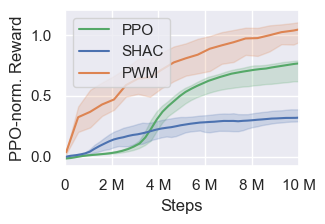

In [7]:
ppo_data = process_step_data_iqm("data/ppo_hopper_stiff.csv", row="global_step", col="rewards/step", downsample=1, smooth=0.7)
shac_data = process_step_data_iqm("data/shac_hopper_stiff.csv", row="global_step", col="rewards/step", smooth=0.7)
pwm_data = process_step_data_iqm("data/pwm_hopper_stiff.csv", row="Step", col="rewards", smooth=0.7)

norm = 4742.296956380208
ppo_data /= norm
shac_data /= norm
pwm_data /= norm

f, ax = plt.subplots(1, 1, figsize=(3.5,2.4))
ax.plot(ppo_data["rewards/step"], label="PPO", color=colors["PPO"])
ax.fill_between(ppo_data.index, ppo_data["rewards/step_min"], ppo_data["rewards/step_max"], alpha=0.2, color=colors["PPO"])
ax.plot(shac_data["rewards/step"], label="SHAC", color=colors["SHAC"])
ax.fill_between(shac_data.index, shac_data["rewards/step_min"], shac_data["rewards/step_max"], alpha=0.2, color=colors["SHAC"])
ax.plot(pwm_data["rewards"], label="PWM", color=colors["PWM"])
ax.fill_between(pwm_data.index, pwm_data["rewards_min"], pwm_data["rewards_max"], alpha=0.2, color=colors["PWM"])
ax.set_xlim((0, 1e7))
ax.xaxis.set_major_formatter(ticker.EngFormatter())
# ax.yaxis.set_major_formatter(ticker.EngFormatter())
plt.xlabel("Steps")
plt.ylabel("PPO-norm. Reward")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/hopper_stiffness.pdf", bbox_inches="tight")

Read 5 for PPO
Read 5 for SHAC
Read 5 for PWM


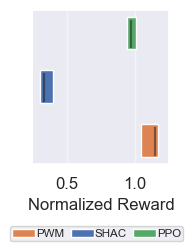

In [355]:
scores = {} 
labels = ["PPO", "SHAC", "PWM"]
for alg, data in zip(labels, [ppo_data, shac_data, pwm_data]):
    col = "rewards" if alg == "PWM" else "rewards/step"
    j = data[col].argmax()
    data = data.drop(col, axis=1)
    vals = data[data.columns[data.columns.str.endswith(f"{col}")]].iloc[j].values
    print(f"Read {len(vals)} for {alg}") 
    scores[alg] = vals[..., None, None]
iqm_scores, iqm_cis = rly.get_interval_estimates(scores, iqm, reps=reps)

fig, ax = plt.subplots(1,1, figsize=(1.75,2.0))
for idx, alg in enumerate(labels[::-1]):
    ax.barh(y=idx, width=iqm_cis[alg][1] - iqm_cis[alg][0], height=0.6, left=iqm_cis[alg][0], color=colors[alg], label=alg)
    ax.vlines(x=iqm_scores[alg],
        ymin=idx - (7.5 * h / 16),
        ymax=idx + (6.5 * h / 16),
        color='k',
        alpha=0.5)

# cleanup grid and axis
ax.spines['left'].set_visible(False)
ax.grid(False)    
ax.grid(True, axis='x', alpha=0.5)    
ax.set_yticks([])
ax.set_xlabel("Normalized Reward", fontsize='medium')
ax.tick_params(axis='both', which='major', labelsize='medium')
ax.set_xlim((0.25, 1.25))
plt.legend(bbox_to_anchor=(1.15, -0.37), fancybox=True, shadow=False, ncols=3, columnspacing=0.5, handletextpad=0.1, borderpad=0.2, fontsize="x-small")
plt.savefig("../figures/hopper_stiffness_agg.pdf", bbox_inches="tight", pad_inches=0)

# World model components ablation

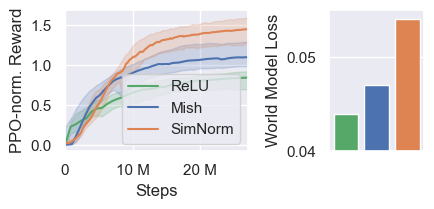

In [10]:
pwm_data = process_step_data_iqm("data/pwm_ant.csv", row="Step", col="rewards", smooth=0.7)
pwm_data_no_sn = process_step_data_iqm("data/pwm_ant_no_simnorm.csv", row="Step", col="rewards", smooth=0.7)
pwm_data_simple = process_step_data_iqm("data/pwm_ant_simple.csv", row="Step", col="rewards", smooth=0.7)

pwm_data_no_sn = pwm_data_no_sn.iloc[8:]
pwm_data_no_sn.index -= pwm_data_no_sn.index[0]

norm = 6604.663357204862
pwm_data /= norm
pwm_data_no_sn /= norm
pwm_data_simple /= norm

# f, ax = plt.subplots(1, 1, figsize=(4,3))
fig, ax = plt.subplot_mosaic("00011", figsize=(4.5,2.25), sharey=False)
ax['0'].plot(pwm_data_simple["rewards"], label="ReLU", color=colors["PPO"])
ax['0'].fill_between(pwm_data_simple.index, pwm_data_simple["rewards_min"], pwm_data_simple["rewards_max"], alpha=0.2, color=colors["PPO"])
ax['0'].plot(pwm_data_no_sn["rewards"], label="Mish", color=colors["SHAC"])
ax['0'].fill_between(pwm_data_no_sn.index, pwm_data_no_sn["rewards_min"], pwm_data_no_sn["rewards_max"], alpha=0.2, color=colors["SHAC"])
ax['0'].plot(pwm_data["rewards"], label="SimNorm", color=colors["PWM"])
ax['0'].fill_between(pwm_data.index, pwm_data["rewards_min"], pwm_data["rewards_max"], alpha=0.2, color=colors["PWM"])
ax['0'].set_xlim((0, 27e6))
ax['0'].xaxis.set_major_formatter(ticker.EngFormatter())
# ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax['0'].set_xlabel("Steps")
ax['0'].set_ylabel("PPO-norm. Reward")
ax['0'].legend()

losses = [0.044, 0.047, 0.054]
ax['1'].bar([0,1,2], losses, color=[colors["PPO"], colors["SHAC"], colors["PWM"]] )
ax['1'].set_xticks([])
ax['1'].set_ylabel("World Model Loss")
ax['1'].set_ylim((0.04, 0.055))
ax['1'].set_yticks([0.04, 0.05])


plt.tight_layout()
plt.savefig("../figures/world_model_ablation.pdf", bbox_inches="tight", pad_inches=0.1)

# Ant policy batch size ablation

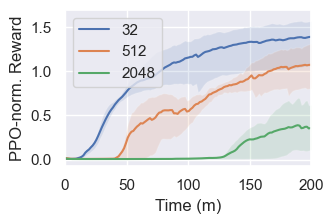

In [9]:
bsz32 = process_time_data_iqm("data/pwm_ant_bsz32.csv", col="rewards", smooth=0.7)
bsz512 = process_time_data_iqm("data/pwm_ant_bsz512.csv", col="rewards", smooth=0.7)
bsz2048 = process_time_data_iqm("data/pwm_ant_bsz2048.csv", col="rewards", smooth=0.7)

norm = 6604.663357204862
bsz32 /= norm
bsz512 /= norm
bsz2048 /= norm

f, ax = plt.subplots(1, 1, figsize=(3.5,2.4))
labels = [32, 512, 2048]
for i, data in enumerate([bsz32, bsz512, bsz2048]):
    ax.plot(data.index.total_seconds()/60, data["rewards"], label=labels[i])
    ax.fill_between(data.index.total_seconds()/60, data["rewards_min"], data["rewards_max"], alpha=0.15)
ax.set_xlim((0, 200))
ax.xaxis.set_major_formatter(ticker.EngFormatter())
plt.xlabel("Time (m)")
plt.ylabel("PPO-norm. Reward")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/batch_size_ablation.pdf", bbox_inches="tight")